## 모델

- SARIMAX
- air
    - drop: 지역, 망, 측정소코드, 측정소명, 주소
    - 결측치: interpolate
- weather
    - drop: QC플래그, 지점, 지점명, 운형(운형약어), 지면상태(지면상태코드), 현상번호(국내식)
    - 결측치: interpolate -> 평균값
    
- 스케일링 여부와 성능 간에는 약간의 관계 (13860 -> 13480)

In [1]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst

# 전처리
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

# 시계열
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta
from itertools import product

# 경고
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
# 함수 선언
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()
    
    plt.show()
    
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

# 0. 데이터 로드

In [3]:
# 학습 데이터 로딩
air_21 = pd.read_csv("air_2021.csv", sep=',', index_col = 0, encoding = 'utf-8' )
air_22 = pd.read_csv("air_2022.csv", sep=',', index_col = 0, encoding = 'utf-8' )

weather_21 = pd.read_csv("weather_2021.csv", sep = ',', encoding='cp949')
weather_22 = pd.read_csv("weather_2022.csv", sep = ',', encoding='cp949')

# 1. 이상치/결측치 처리

In [4]:
# air column drop
air_21 = air_21.drop(columns = ['지역', '망', '측정소코드', '측정소명', '주소'])
air_22 = air_22.drop(columns = ['지역', '망', '측정소코드', '측정소명', '주소'])

In [5]:
# Imputer
#imp = IterativeImputer(estimator=RandomForestRegressor)
#imp.fit(air_21)
#air_21 = pd.DataFrame(imp.transform(air_21), columns = air_21.columns)

# interpolate
air_21.interpolate(method = 'linear', inplace = True)
air_22.interpolate(method = 'linear', inplace = True)

In [6]:
columns = ['지점', 
           '지점명', 
           '기온 QC플래그',
           '강수량 QC플래그',
           '풍속 QC플래그',
           '풍향 QC플래그',
           '습도 QC플래그',
           '현지기압 QC플래그',
           '해면기압 QC플래그',
           '일조 QC플래그',
           '일사 QC플래그',
           '운형(운형약어)',
           '지면상태(지면상태코드)',
           '현상번호(국내식)',
           '지면온도 QC플래그']

weather_21 = weather_21.drop(columns = columns)
weather_22 = weather_22.drop(columns = columns)

In [7]:
# train
weather_21.interpolate(method = 'linear', inplace = True) 
weather_21['강수량(mm)'] = weather_21['강수량(mm)'].fillna(weather_21['강수량(mm)'].mean())
weather_21['일조(hr)'] = weather_21['일조(hr)'].fillna(weather_21['일조(hr)'].mean())
weather_21['일사(MJ/m2)'] = weather_21['일사(MJ/m2)'].fillna(weather_21['일사(MJ/m2)'].mean())
weather_21['적설(cm)'] = weather_21['적설(cm)'].fillna(weather_21['적설(cm)'].mean())
weather_21['3시간신적설(cm)'] = weather_21['3시간신적설(cm)'].fillna(weather_21['3시간신적설(cm)'].mean())
weather_21['최저운고(100m )'] = weather_21['최저운고(100m )'].fillna(weather_21['최저운고(100m )'].mean())

# test
weather_22.interpolate(method = 'linear', inplace = True) 
weather_22['강수량(mm)'] = weather_22['강수량(mm)'].fillna(weather_22['강수량(mm)'].mean())
weather_22['일조(hr)'] = weather_22['일조(hr)'].fillna(weather_22['일조(hr)'].mean())
weather_22['일사(MJ/m2)'] = weather_22['일사(MJ/m2)'].fillna(weather_22['일사(MJ/m2)'].mean())
weather_22['적설(cm)'] = weather_22['적설(cm)'].fillna(weather_22['적설(cm)'].mean())
weather_22['3시간신적설(cm)'] = weather_22['3시간신적설(cm)'].fillna(weather_22['3시간신적설(cm)'].mean())
weather_22['최저운고(100m )'] = weather_22['최저운고(100m )'].fillna(weather_22['최저운고(100m )'].mean())

#### time 변수 생성하기

#### air

In [8]:
# train
air_21['측정일시'] = air_21['측정일시'].astype(str)
t = air_21['측정일시']
converted_time = t.str.slice(stop=-2) + t.str.slice(start=-2).map(lambda x: str(int(x)-1).zfill(2))
air_21['측정일시'] = pd.to_datetime(converted_time, format='%Y%m%d%H')
air_21 = air_21.rename(columns = {'측정일시': 'time'})

In [9]:
# test
air_22['측정일시'] = air_22['측정일시'].astype(str)
t = air_22['측정일시']
converted_time = t.str.slice(stop=-2) + t.str.slice(start=-2).map(lambda x: str(int(x)-1).zfill(2))
air_22['측정일시'] = pd.to_datetime(converted_time, format='%Y%m%d%H')
air_22 = air_22.rename(columns = {'측정일시': 'time'})

#### weather

In [10]:
weather_21['time']=weather_21['일시']
weather_21['time']=pd.to_datetime(weather_21['time'])

col1=weather_21.columns[-1:].to_list()
col2=weather_21.columns[:-1].to_list()
new_col=col1+col2
weather_21=weather_21[new_col]

weather_21.drop(columns = ['일시'], inplace = True)

In [11]:
weather_22['time']=weather_22['일시']
weather_22['time']=pd.to_datetime(weather_22['time'])

col1=weather_22.columns[-1:].to_list()
col2=weather_22.columns[:-1].to_list()
new_col=col1+col2
weather_22=weather_22[new_col]

weather_22.drop(columns = ['일시'], inplace = True)

# 2. 데이터 병합

#### air 21, 22 시간순으로 정렬

In [12]:
air_21.sort_values(by=['time'], axis=0, inplace=True)
air_22.sort_values(by=['time'], axis=0, inplace=True)

#### train set 병합

In [13]:
df_21 =  pd.merge(air_21, weather_21, how='outer', on='time')

#### test set 병합

In [14]:
df_22 = pd.merge(air_22, weather_22, how='outer', on='time')

# 3. t+1 시점 생성 후 모델링

### df_21

In [15]:
# shift
df_21['y'] = df_21['PM10'].shift(-1)

# 제일 마지막 행은 삭제, 결측치가 포함된 첫행도 삭제
df_21.dropna(axis = 0, inplace = True)

In [16]:
target = 'y'

x = df_21.drop([target, 'time'], axis = 1)
y = df_21.loc[:, target]

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 15, shuffle = False)

In [18]:
x_train.shape, x_val.shape

((8743, 28), (15, 28))

In [19]:
# 스케일링
scaler1 = MinMaxScaler()
x_train_s1 = scaler1.fit_transform(x_train)
x_val_s1 = scaler1.transform(x_val)

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


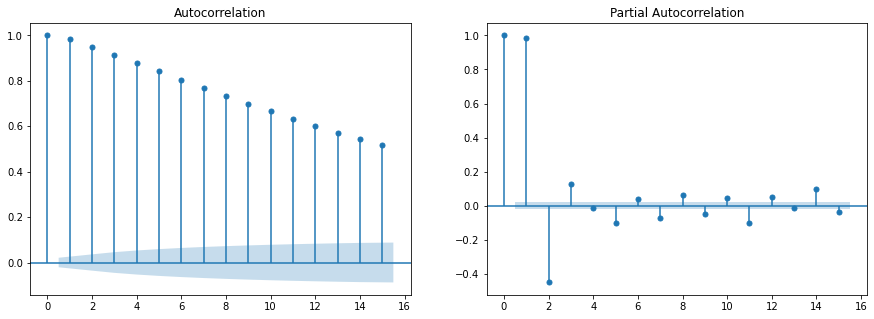

In [20]:
# 평균 모델
residual_diag(y_train, lags=15)

# ARIMA

In [21]:
model = sm.tsa.SARIMAX(y_train, order=(1,0,1)).fit()

잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


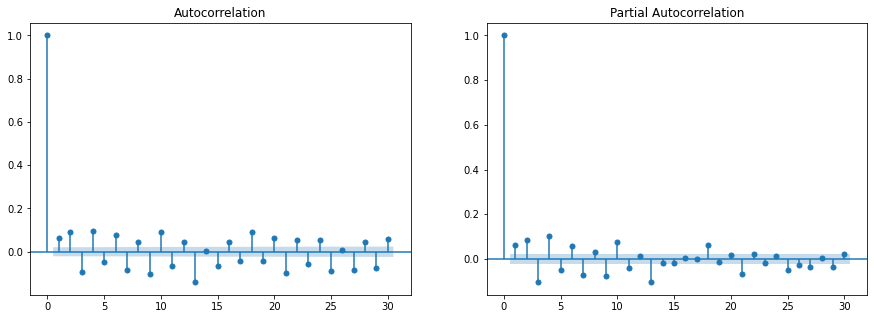

In [22]:
# model.predict() # train에 대한 pred 값
residuals = model.resid # y_train과 pred의 차이 -> train 데이터 이후에 대한 pred 값
residual_diag(residuals)

In [23]:
# AIC
print('model AIC :', model.aic)

# Validation
pred = model.forecast(15)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE :', mean_absolute_percentage_error(y_val, pred))

model AIC : 61223.73902387218
MAE : 4.684173179753354
MAPE : 0.1954425249785465


In [24]:
# 하이퍼파라미터 튜닝
p = [1,2,3,4]
q = [1,2,3,4]
d = [1]
iter = list(product(p,d,q))

mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(15)
    mae.append(mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)


In [25]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic' : aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
10,"(3, 1, 3)",2.47759,60500.506211


,"params(p,d,q)",mae,aic
7,"(2, 1, 4)",2.553997,60488.479785


In [34]:
model_t = sm.tsa.SARIMAX(y_train, order=(3,1,3)).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


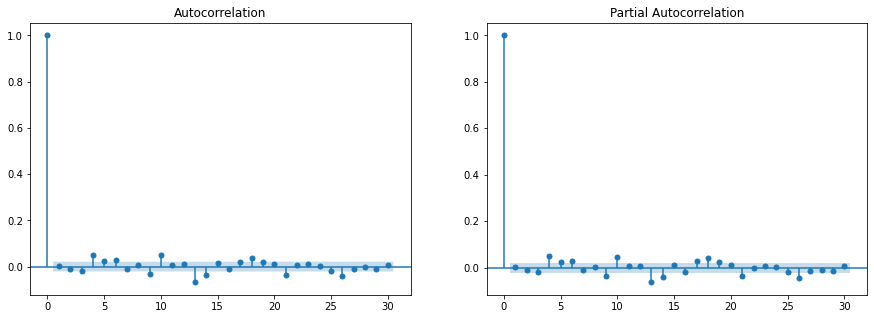

In [35]:
residuals = model_t.resid
residual_diag(residuals)

In [36]:
# AIC
print('model_t AIC :', model_t.aic)

# Valid
pred = model_t.forecast(15)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

model_t AIC : 60500.506210861415
MAE : 2.4775901975018693
MAPE: 0.11628317303619568


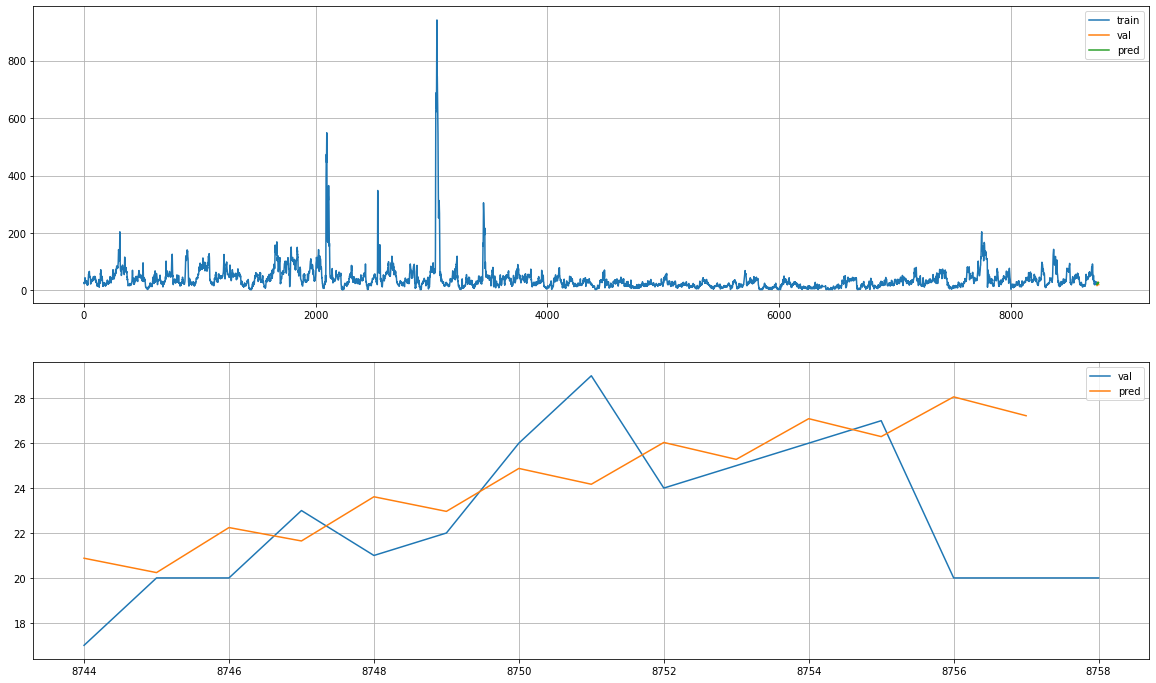

In [37]:
plot_model_result(y_train, y_val, pred)

# SARIMA

In [38]:
model_sarima = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(1,1,1,7)).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


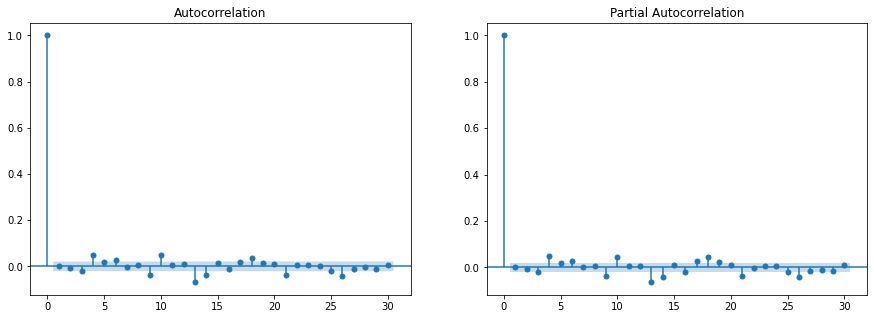

In [39]:
residuals = model_sarima.resid
residual_diag(residuals)

In [40]:
# AIC
print('model_sarima :', model_sarima.aic)

# Valid
pred = model_sarima.forecast(15)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE :', mean_absolute_percentage_error(y_val, pred))

model_sarima : 60519.251659163296
MAE : 2.532655328542725
MAPE : 0.11896340338786367


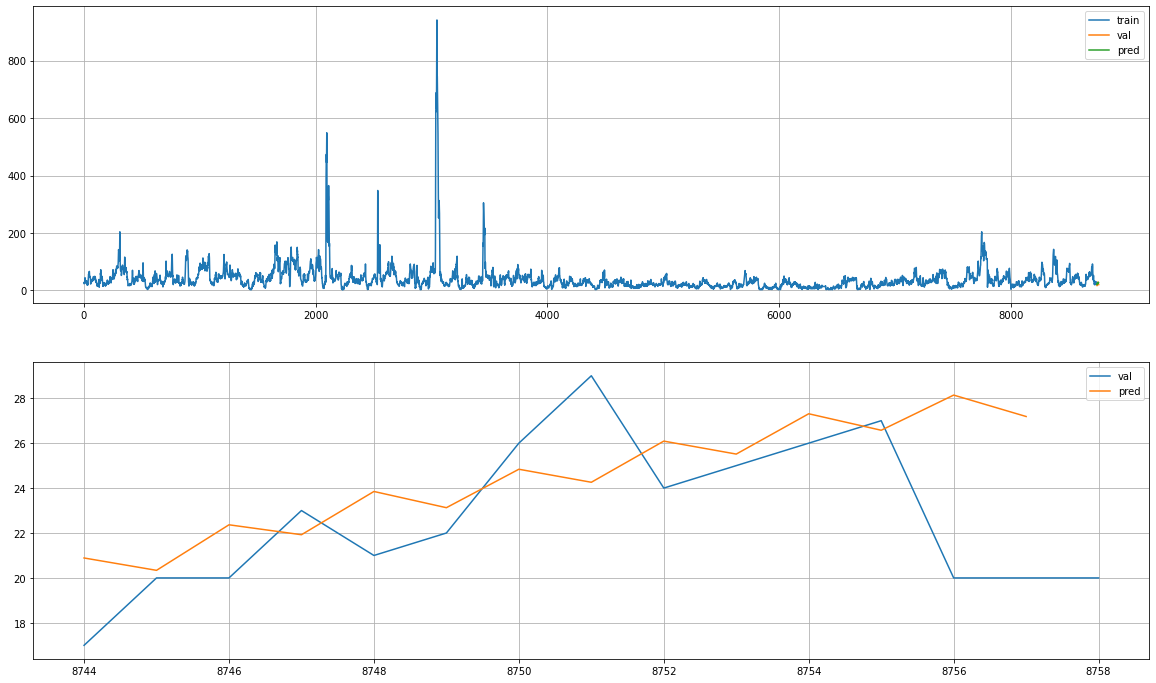

In [41]:
plot_model_result(y_train, y_val, pred)

In [42]:
P = [1,2,3]
Q = [1,2,3]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(i[0],i[1],i[2],7)).fit()
    pred = model_fit.forecast(15)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


In [43]:
result = pd.DataFrame({'params(P,D,Q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q)",mae,aic
3,"(2, 1, 1)",2.413598,60506.367652


,"params(P,D,Q)",mae,aic
6,"(3, 1, 1)",2.436151,60498.372867


In [44]:
model_sarima_t = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(3,1,1,7)).fit()

In [45]:
# AIC
print('model_sarima_t :', model_sarima_t.aic)

# Valid
pred = model_sarima_t.forecast(15)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

model_sarima_t : 60498.37286732794
MAE : 2.436151135806195
MAPE: 0.11067697542316995


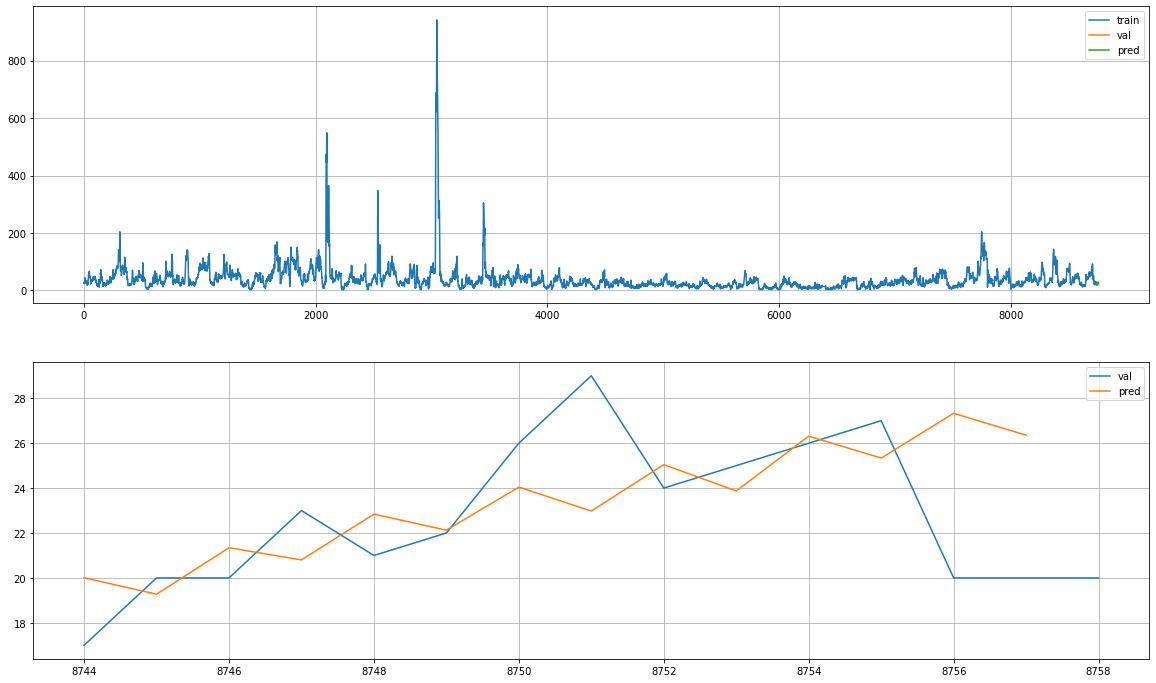

In [46]:
plot_model_result(y_train, y_val, pred)

# SARIMAX

In [21]:
model_sarimax = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(3,1,1,7), exog=x_train_s1).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


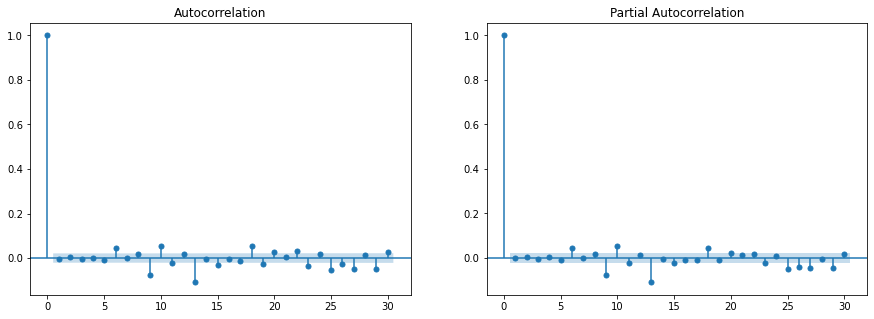

In [22]:
residuals = model_sarimax.resid 
residual_diag(residuals)

In [23]:
# AIC
print('SARIMAX AIC :', model_sarimax.aic)

# Valid
pred = model_sarimax.forecast(15, exog=x_val_s1)
print('MAE :', mean_absolute_error(y_val, pred)) 
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

SARIMAX AIC : 60778.4247855821
MAE : 2.633030913298108
MAPE: 0.11172023738522102


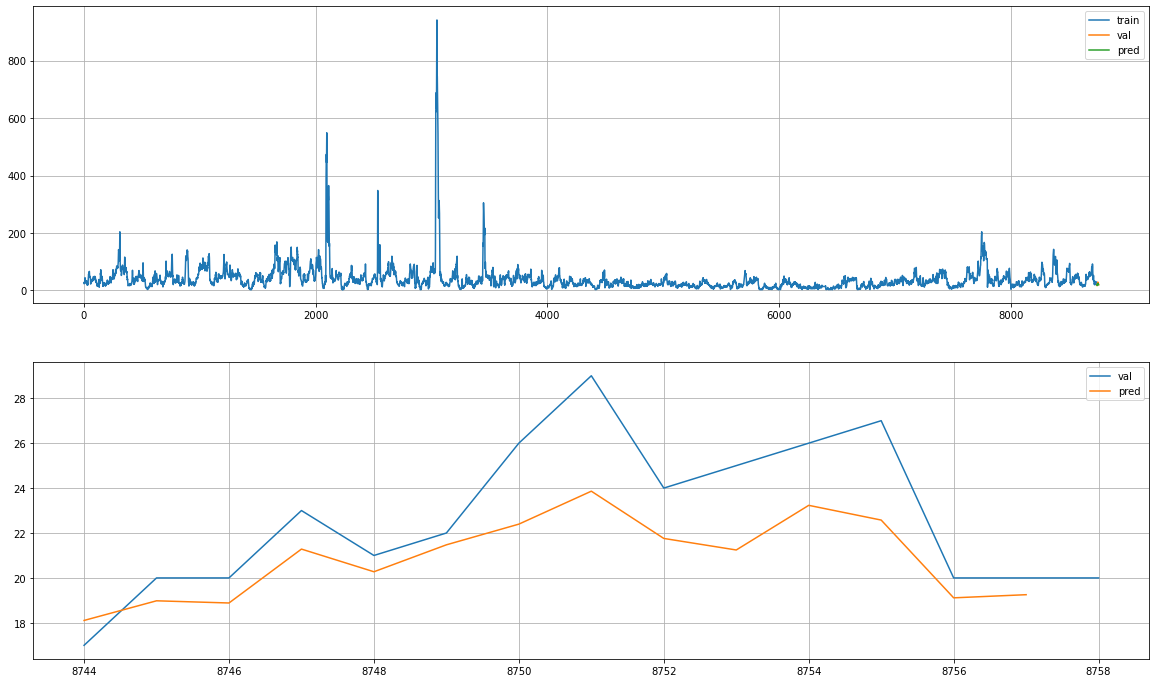

In [24]:
plot_model_result(y_train, y_val, pred)

### df_22

In [25]:
# shift
df_22['y'] = df_22['PM10'].shift(-1)

# 제일 마지막 행은 삭제
df_22.dropna(axis = 0, inplace = True)

In [26]:
target = 'y'

x2 = df_22.drop([target, 'time'], axis = 1)
y2 = df_22.loc[:, target]

In [27]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(x2, y2, test_size = 15, shuffle = False)

In [28]:
x_train2.shape, x_val2.shape

((2144, 28), (15, 28))

In [29]:
# 스케일링
scaler2 = MinMaxScaler()
x_train_s2 = scaler2.fit_transform(x_train2)
x_val_s2 = scaler2.transform(x_val2)

# SARIMAX

In [30]:
model_sarimax2 = sm.tsa.SARIMAX(y_train2, order=(3,1,3), seasonal_order=(3,1,1,7), exog=x_train_s2).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


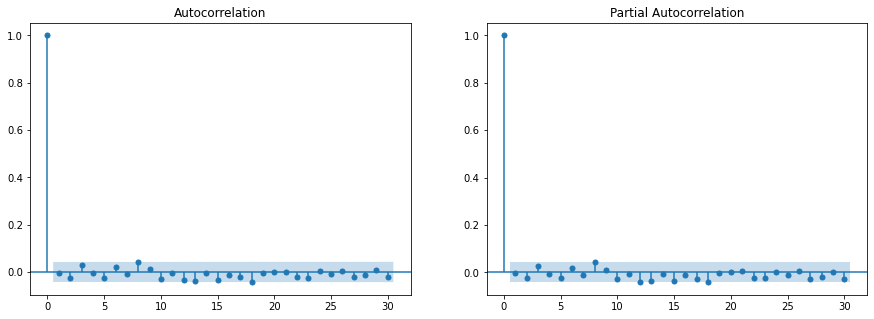

In [31]:
residuals2 = model_sarimax2.resid
residual_diag(residuals2)

In [32]:
# AIC
print('SARIMAX AIC :', model_sarimax2.aic)

# Valid
pred2 = model_sarimax2.forecast(15, exog=x_val_s2)
print('MAE :', mean_absolute_error(y_val2, pred2)) 
print('MAPE:', mean_absolute_percentage_error(y_val2, pred2))

SARIMAX AIC : 13480.945926276414
MAE : 3.853621119276163
MAPE: 0.37597284814964643


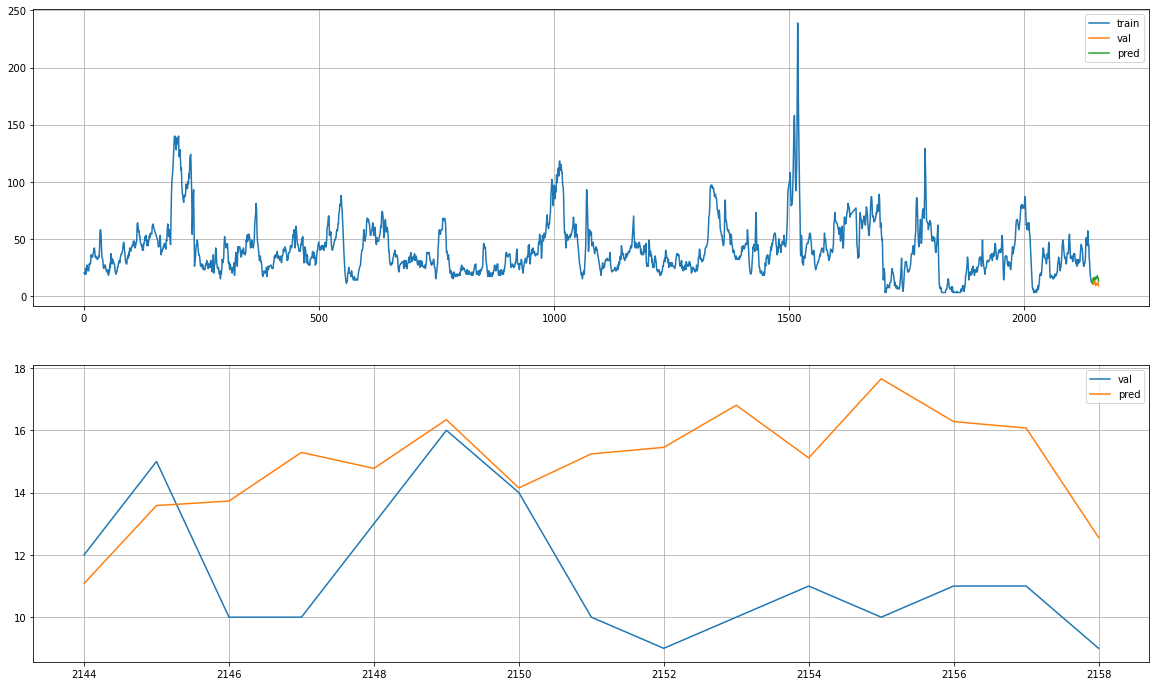

In [33]:
plot_model_result(y_train2, y_val2, pred2)